In [1]:
%load_ext autoreload
%autoreload 2

import json
import os.path as osp
import os,sys
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

from torch_geometric.utils import to_undirected
from torch_cluster import radius_graph, knn_graph
from torch_geometric.datasets import MNISTSuperpixels
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from tqdm import tqdm
import argparse
import warnings
warnings.simplefilter('ignore')
from time import strftime, gmtime

sys.path.append('../')
import utils
import model.net as net
import model.data_loader as data_loader
from evaluate import evaluate

In [2]:
torch.__version__

'1.10.2+cu102'

In [3]:
!python --version

Python 3.8.8


### Import data

In [4]:
'''
pre_fix = '/export/home/phys/kyungmip/L1DeepMETv2/'

data_dir = pre_fix + 'data_ttbar/'        # name of the input data folder

dataloaders = data_loader.fetch_dataloader(data_dir = data_dir, batch_size=1, validation_split=.2)

train_dl = dataloaders['train']
test_dl = dataloaders['test']

print('Training dataloader: {}, Test dataloader: {}'.format(len(train_dl), len(test_dl)))

torch.save(test_dl, 'test_dataloader_per_event.pth')
'''

"\npre_fix = '/export/home/phys/kyungmip/L1DeepMETv2/'\n\ndata_dir = pre_fix + 'data_ttbar/'        # name of the input data folder\n\ndataloaders = data_loader.fetch_dataloader(data_dir = data_dir, batch_size=1, validation_split=.2)\n\ntrain_dl = dataloaders['train']\ntest_dl = dataloaders['test']\n\nprint('Training dataloader: {}, Test dataloader: {}'.format(len(train_dl), len(test_dl)))\n\ntorch.save(test_dl, 'test_dataloader_per_event.pth')\n"

In [5]:
test_dl = torch.load('test_dataloader_per_event.pth')
#test_dl = torch.load('test_dataloader.pth')

In [21]:
evt_idx = 10

In [22]:
for cnt, test_data in enumerate(test_dl):
    x_cont = test_data.x[:, :6]  # include puppi
    x_cat = test_data.x[:, 6:].long()
    
    etaphi = torch.cat([test_data.x[:, 3][:, None], test_data.x[:, 4][:, None]], dim=1)
    batch = test_data.batch[:]
    
    weights_puppi = test_data.x[:, 5]
    
    genMETx = test_data.y[:, 0]
    genMETy = test_data.y[:, 1]
    
    if cnt == evt_idx:
        break

### Send data to GPU

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [24]:
CUDA_LAUNCH_BLOCKING=1

In [25]:
'''
x_cont_test = test_data.x[:128, :6].to(device)  # include puppi
x_cat_test = test_data.x[:128, 6:].long().to(device)

etaphi_test = torch.cat([test_data.x[:128, 3][:, None], test_data.x[:128, 4][:, None]], dim=1).to(device=device)
batch = test_data.batch[:128].to(device)
edge_index_test = radius_graph(etaphi_test, r=0.4, batch=batch, loop=False, max_num_neighbors=255).to(device=device)

scale_momentum = 128
norm = torch.tensor([1./scale_momentum, 1./scale_momentum, 1./scale_momentum, 1., 1., 1.]).to(device=device)
'''

'\nx_cont_test = test_data.x[:128, :6].to(device)  # include puppi\nx_cat_test = test_data.x[:128, 6:].long().to(device)\n\netaphi_test = torch.cat([test_data.x[:128, 3][:, None], test_data.x[:128, 4][:, None]], dim=1).to(device=device)\nbatch = test_data.batch[:128].to(device)\nedge_index_test = radius_graph(etaphi_test, r=0.4, batch=batch, loop=False, max_num_neighbors=255).to(device=device)\n\nscale_momentum = 128\nnorm = torch.tensor([1./scale_momentum, 1./scale_momentum, 1./scale_momentum, 1., 1., 1.]).to(device=device)\n'

In [26]:
x_cont_test = x_cont.to(device)  # include puppi
x_cat_test = x_cat.long().to(device)

etaphi_test = etaphi.to(device=device)
batch = batch.to(device)

edge_index_test = radius_graph(etaphi_test, r=0.4, batch=batch, loop=False, max_num_neighbors=255).to(device=device)

weights_puppi = weights_puppi.to(device)

genMETx = genMETx.to(device)
genMETy = genMETy.to(device)

scale_momentum = 1 # scale some of input continuous features 
norm = torch.tensor([1./scale_momentum, 1./scale_momentum, 1./scale_momentum, 1., 1., 1.]).to(device=device)

In [27]:
print(f'x_cont_test: {x_cont_test.shape}')
print(f'x_cat_test: {x_cat_test.shape}')
print(f'etaphi: {etaphi_test.shape}')
print(f'batch: {batch.shape}')
print(f'weights_puppi: {weights_puppi.shape}')
print(f'genMETx: {genMETx.shape}')
print(f'genMETy: {genMETy.shape}')
print(f'edge_index: {edge_index_test.shape}')

print(f'\nThis event has {batch.shape[0]} PUPPI candidates ("visible" particles).')

x_cont_test: torch.Size([48, 6])
x_cat_test: torch.Size([48, 2])
etaphi: torch.Size([48, 2])
batch: torch.Size([48])
weights_puppi: torch.Size([48])
genMETx: torch.Size([1])
genMETy: torch.Size([1])
edge_index: torch.Size([2, 80])

This event has 48 PUPPI candidates ("visible" particles).


### Restore ckpts

In [28]:
prefix = '/export/home/phys/kyungmip/L1DeepMETv2/ckpts_April30_scale_sigmoid/'
restore_ckpt = osp.join(prefix, 'last.pth.tar')

In [29]:
model_new = net.Net(continuous_dim=6, categorical_dim=2 , norm=norm).to(device)

In [30]:
param_restored_new = utils.load_checkpoint(restore_ckpt, model_new)
param_restored_new

{'epoch': 59,
 'state_dict': OrderedDict([('graphnet.embed_charge.weight',
               tensor([[ 0.9162, -1.0583, -0.9913,  0.0119, -1.2548,  0.3014, -0.3680, -0.0259],
                       [ 1.1693, -1.1932, -0.4266, -0.7048, -0.3579,  0.5363,  1.0058, -0.7791],
                       [-1.1897, -0.7676,  0.9433,  0.2918, -0.2274, -1.3644,  0.6979,  0.4962]],
                      device='cuda:0')),
              ('graphnet.embed_pdgid.weight',
               tensor([[-2.0383, -0.3847, -0.2413,  0.9122, -0.4805,  0.2302, -0.4746,  0.9317],
                       [-0.4117,  1.3556,  0.8550,  0.9977, -0.1622,  1.0582, -0.3220, -0.1858],
                       [ 0.3332, -1.7245,  0.2467,  0.0240, -1.0826, -0.7612, -0.2514, -1.4249],
                       [-0.0923,  0.4527, -0.2330,  1.5905, -0.3753, -1.6111,  0.4285,  0.3514],
                       [-0.8122, -1.1400, -0.2369, -0.4227,  0.0108, -1.9788, -0.4649, -1.3263],
                       [ 0.1619,  0.1169, -0.4400,  0.8138, -

In [32]:
results_new = model_new(x_cont_test, x_cat_test, edge_index_test, batch)
results_new

tensor([0.7400, 0.9952, 0.9808, 0.9801, 0.7782, 0.8012, 1.0000, 0.9270, 1.0000,
        1.0000, 1.0000, 0.9998, 0.9998, 0.9999, 0.9595, 0.9999, 0.9903, 0.9397,
        0.9381, 0.9472, 0.9047, 0.9999, 0.9277, 0.9347, 0.9162, 0.9479, 1.0000,
        1.0000, 1.0000, 0.9818, 0.9410, 0.9113, 0.8964, 0.8335, 0.5720, 0.8565,
        0.7814, 0.9365, 0.7394, 0.9725, 0.9334, 0.9755, 0.9393, 0.9998, 0.9585,
        0.9797, 0.9412, 0.9902], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [34]:
# Print parameters of the instantiated model
print("Parameters of the instantiated model:")
for name, param in model_new.named_parameters():
    print(f"{name}: {param.size()}")
    print(param)

Parameters of the instantiated model:
graphnet.embed_charge.weight: torch.Size([3, 8])
Parameter containing:
tensor([[ 0.9162, -1.0583, -0.9913,  0.0119, -1.2548,  0.3014, -0.3680, -0.0259],
        [ 1.1693, -1.1932, -0.4266, -0.7048, -0.3579,  0.5363,  1.0058, -0.7791],
        [-1.1897, -0.7676,  0.9433,  0.2918, -0.2274, -1.3644,  0.6979,  0.4962]],
       device='cuda:0', requires_grad=True)
graphnet.embed_pdgid.weight: torch.Size([7, 8])
Parameter containing:
tensor([[-2.0383, -0.3847, -0.2413,  0.9122, -0.4805,  0.2302, -0.4746,  0.9317],
        [-0.4117,  1.3556,  0.8550,  0.9977, -0.1622,  1.0582, -0.3220, -0.1858],
        [ 0.3332, -1.7245,  0.2467,  0.0240, -1.0826, -0.7612, -0.2514, -1.4249],
        [-0.0923,  0.4527, -0.2330,  1.5905, -0.3753, -1.6111,  0.4285,  0.3514],
        [-0.8122, -1.1400, -0.2369, -0.4227,  0.0108, -1.9788, -0.4649, -1.3263],
        [ 0.1619,  0.1169, -0.4400,  0.8138, -1.5202,  2.1544,  1.1116, -1.5124],
        [-2.0252,  0.8904,  1.1302, -1

In [35]:
epoch = param_restored_new['epoch']

### Load Torch Script Jit Model

In [71]:
# prefix = '../ckpts_April30_scale_sigmoid/'

In [72]:
# model_jit = torch.jit.load(f'{prefix}/MODELS/scripted_model_epoch{epoch}.pt').to(device)

In [19]:
# print("Parameters of the jit model:")
# for name, param in model_jit.named_parameters():
#    print(f"{name}: {param.size()}")
#    print(param)

In [20]:
# results_jit = model_jit(x_cont_test, x_cat_test, edge_index_test, batch)
# results_jit

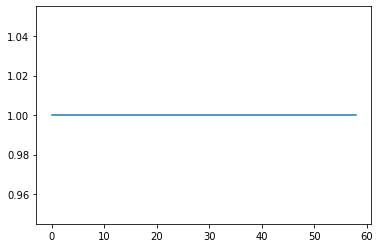

In [75]:
# import numpy as np
# import matplotlib.pyplot as plt

# ratio = results_new.cpu().detach().numpy() / results_jit.cpu().detach().numpy()
# plt.plot(range(len(ratio)), ratio)

### Model prediction -- regressed MET; compare with baseline algo

In [37]:
from torch_scatter import scatter_add

In [38]:
weights = results_new.to(device)

In [55]:
px = x_cont_test[:,1]
py = x_cont_test[:,2]

# regress uT: MET = (-1)*uT
# ML weights are [0,1]
uTx = scatter_add(weights*px, batch)
uTy = scatter_add(weights*py, batch)

# regressed MET
METx = (-1) * uTx
METy = (-1) * uTy

v_MET=torch.stack((METx, METy),dim=1).detach().cpu()

In [56]:
v_MET

tensor([[-35.8036, -69.6341]])

In [57]:
# qT is the genMET
qTx = genMETx
qTy = genMETy

v_qT=torch.stack((qTx,qTy),dim=1).detach().cpu()

In [58]:
v_qT

tensor([[-31.1738, -67.9581]])

In [59]:
# baseline: PUPPI MET

# PUPPI MET using PUPPI weights

puppiMETx = (-1)*scatter_add(weights_puppi*px, batch)
puppiMETy = (-1)*scatter_add(weights_puppi*py, batch)

v_puppiMET = torch.stack((puppiMETx, puppiMETy),dim=1).detach().cpu()

In [60]:
v_puppiMET

tensor([[ -21.7718, -114.8464]])

In [61]:
# tensor operations
def getdot(vx, vy):
    return torch.einsum('bi,bi->b',vx,vy)

def getscale(vx):
    return torch.sqrt(getdot(vx,vx))

def scalermul(a,v):
    return torch.einsum('b,bi->bi',a,v)

In [72]:
def compute(vector):
    #response = getdot(vector,v_qT)/getdot(v_qT,v_qT)
    response = getscale(vector)/getscale(v_qT)

    v_paral_predict = scalermul(response, v_qT)
    u_paral_predict = getscale(v_paral_predict) - getscale(v_qT)
    v_perp_predict = vector - v_paral_predict
    u_perp_predict = getscale(v_perp_predict)
    
    return [u_perp_predict.numpy(), u_paral_predict.numpy(), response.numpy()]

In [73]:
resolutions_arr = {}

resolutions_arr['GNNMET'] = compute(v_MET)
resolutions_arr['puppiMET'] = compute(v_puppiMET)

In [76]:
print(f'Checking for event #{evt_idx}')
for met in resolutions_arr.keys():
    print(f'\n{met}')
    print(f'Perpendicular scaled resolution (ideally 0): {resolutions_arr[met][0].item():.2f}')
    print(f'Parallel scaled resolution (ideally 0): {resolutions_arr[met][1].item():.2f}')
    print(f'Response (ideally 1): {resolutions_arr[met][2].item():.2f}')

Checking for event #10

GNNMET
Perpendicular scaled resolution (ideally 0): 3.51
Parallel scaled resolution (ideally 0): 3.53
Response (ideally 1): 1.05

puppiMET
Perpendicular scaled resolution (ideally 0): 28.30
Parallel scaled resolution (ideally 0): 42.12
Response (ideally 1): 1.56
